In [ ]:
# ============================================
# 1. Import Required Libraries
# ============================================
import pandas as pd
import re
import numpy as np

# ============================================
# 2. Load the Dataset
# ============================================
df = pd.read_csv("/content/SaudiIrony.csv")
TEXT_COLUMN = "Tweets with Decoded emojis"

print("Initial dataset size:", len(df))


# ============================================
# 3. Normalize the text column (convert to string)
# ============================================
df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str)


# ============================================
# 4. Smart Removal of Corrupted or Meaningless Rows
#    → Only remove tweets that have NO useful content
# ============================================

def is_bad_row(text):
    """
    Determines whether a row should be removed entirely.
    A row is removed ONLY IF the whole tweet is invalid:
      - pure NaN / None / ERROR
      - tweet is ONLY a URL, ONLY a mention, ONLY a hashtag
      - contains no meaningful Arabic/English characters
    """
    # True NaN values
    if pd.isna(text):
        return True

    t = str(text).strip().lower()

    # Fully invalid entries
    if t in ["nan", "none", "null", "", "#error!", "error", "na"]:
        return True

    # Tweet is ONLY a URL
    if re.fullmatch(r"(http\S+|www\.\S+)", t):
        return True

    # Tweet is ONLY a mention
    if re.fullmatch(r"@\w+", t):
        return True

    # Tweet is ONLY a hashtag
    if re.fullmatch(r"#\w+", t):
        return True

    # If tweet contains real language (Arabic/English), keep it
    if re.search(r"[a-zA-Z\u0600-\u06FF]", t):
        return False

    # Otherwise: no valid content → remove it
    return True


# Apply detection
mask_bad = df[TEXT_COLUMN].apply(is_bad_row)
removed_rows = df[mask_bad]

print("\n Rows that will be REMOVED (invalid entries):")
display(removed_rows[[TEXT_COLUMN]].head(174))
print("Total removed:", mask_bad.sum())

# Remove bad rows
df = df[~mask_bad].copy()


# ============================================
# 5. Replace Textual Emojis → Real Emojis
#    (done BEFORE cleaning to preserve meaning)
# ============================================

def extract_emoji_names(text):
    return re.findall(r':[a-zA-Z0-9_+-]+:', str(text))

# The manual emoji map you provided
manual_map = {
 ":1st_place_medal:": "🥇",
    ":adult:": "🧑",
    ":algeria:": "🇩🇿",
    ":alien:": "👽",
    ":angel:": "😇",
    ":angry:": "😠",
    ":anguished:": "😧",
    ":apple:": "🍎",
    ":arrow_down:": "⬇️",
    ":arrow_heading_down:": "⤵️",
    ":arrow_left:": "⬅️",
    ":arrow_upper_left:": "↖️",
    ":art:": "🎨",
    ":articulated_lorry:": "🚛",
    ":asterisk:": "*️⃣",
    ":astonished:": "😲",
    ":austria:": "🇦🇹",
    ":baby:": "👶",
    ":baby_bottle:": "🍼",
    ":bahrain:": "🇧🇭",
    ":balance_scale:": "⚖️",
    ":balloon:": "🎈",
    ":bangbang:": "‼️",
    ":bar_chart:": "📊",
    ":basketball:": "🏀",
    ":black_flag:": "🏴",
    ":black_heart:": "🖤",
    ":black_nib:": "✒️",
    ":blossom:": "🌼",
    ":blue_heart:": "💙",
    ":blush:": "😊",
    ":books:": "📚",
    ":bouquet:": "💐",
    ":bow:": "🙇",
    ":boy:": "👦",
    ":brain:": "🧠",
    ":bread:": "🍞",
    ":bricks:": "🧱",
    ":briefcase:": "💼",
    ":broken_heart:": "💔",
    ":bulb:": "💡",
    ":burrito:": "🌯",
    ":bust_in_silhouette:": "👤",
    ":butterfly:": "🦋",
    ":call_me_hand:": "🤙",
    ":camera:": "📷",
    ":candy:": "🍬",
    ":canned_food:": "🥫",
    ":cartwheeling:": "🤸",
    ":cd:": "💿",
    ":chart:": "💹",
    ":cherry_blossom:": "🌸",
    ":child:": "🧒",
    ":clap:": "👏",
    ":clapper:": "🎬",
    ":cloud:": "☁️",
    ":clown_face:": "🤡",
    ":coffee:": "☕",
    ":coffin:": "⚰️",
    ":cold_face:": "🥶",
    ":cold_sweat:": "😰",
    ":collision:": "💥",
    ":comet:": "☄️",
    ":confetti_ball:": "🎊",
    ":confounded:": "😖",
    ":confused:": "😕",
    ":cookie:": "🍪",
    ":corn:": "🌽",
    ":cow2:": "🐄",
    ":cowboy_hat_face:": "🤠",
    ":crescent_moon:": "🌙",
    ":crossed_fingers:": "🤞",
    ":crossed_swords:": "⚔️",
    ":crown:": "👑",
    ":cry:": "😢",
    ":crying_cat_face:": "😿",
    ":cupid:": "💘",
    ":cursing_face:": "🤬",
    ":cut_of_meat:": "🥩",
    ":cyclone:": "🌀",
    ":dancer:": "💃",
    ":dancers:": "👯",
    ":dash:": "💨",
    ":diamonds:": "♦️",
    ":disappointed:": "😞",
    ":disappointed_relieved:": "😥",
    ":disguised_face:": "🥸",
    ":dizzy:": "💫",
    ":dizzy_face:": "😵",
    ":dog:": "🐶",
    ":dog2:": "🐕",
    ":dollar:": "💵",
    ":dove:": "🕊️",
    ":drooling_face:": "🤤",
    ":duck:": "🦆",
    ":eagle:": "🦅",
    ":ear_of_rice:": "🌾",
    ":egypt:": "🇪🇬",
    ":envelope_with_arrow:": "📩",
    ":es:": "🇪🇸",
    ":european_union:": "🇪🇺",
    ":evergreen_tree:": "🌲",
    ":exploding_head:": "🤯",
    ":expressionless:": "😑",
    ":eyes:": "👀",
    ":face_with_head_bandage:": "🤕",
    ":face_with_thermometer:": "🤒",
    ":facepalm:": "🤦",
    ":fairy:": "🧚",
    ":fallen_leaf:": "🍂",
    ":fearful:": "😨",
    ":female_sign:": "♀️",
    ":fire:": "🔥",
    ":fish:": "🐟",
    ":fist:": "✊",
    ":fist_right:": "🤜",
    ":flight_departure:": "🛫",
    ":flushed:": "😳",
    ":foot:": "🦶",
    ":footprints:": "👣",
    ":four_leaf_clover:": "🍀",
    ":fr:": "🇫🇷",
    ":frog:": "🐸",
    ":frowning_face:": "☹️",
    ":frowning_person:": "🙍",
    ":fu:": "🖕",
    ":fuelpump:": "⛽",
    ":full_moon_with_face:": "🌝",
    ":gem:": "💎",
    ":ghost:": "👻",
    ":goat:": "🐐",
    ":green_heart:": "💚",
    ":grimacing:": "😬",
    ":grin:": "😁",
    ":grinning:": "😀",
    ":gun:": "🔫",
    ":hand_over_mouth:": "🤭",
    ":handshake:": "🤝",
    ":hatching_chick:": "🐣",
    ":hear_no_evil:": "🙉",
    ":heart:": "❤️",
    ":heart_decoration:": "💟",
    ":heart_eyes:": "😍",
    ":heart_eyes_cat:": "😻",
    ":heartbeat:": "💓",
    ":heartpulse:": "💗",
    ":hearts:": "❤️",
    ":heavy_check_mark:": "✔️",
    ":heavy_dollar_sign:": "💲",
    ":heavy_exclamation_mark:": "❗",
    ":heavy_heart_exclamation:": "❣️",
    ":herb:": "🌿",
    ":hibiscus:": "🌺",
    ":high_heel:": "👠",
    ":hiking_boot:": "🥾",
    ":hot_face:": "🥵",
    ":hourglass_flowing_sand:": "⏳",
    ":house:": "🏠",
    ":house_with_garden:": "🏡",
    ":hugs:": "🤗",
    ":hushed:": "😯",
    ":imp:": "👿",
    ":inbox_tray:": "📥",
    ":information_desk_person:": "💁",
    ":innocent:": "😇",
    ":interrobang:": "⁉️",
    ":iran:": "🇮🇷",
    ":iraq:": "🇮🇶",
    ":it:": "🇮🇹",
    ":japanese_goblin:": "👺",
    ":japanese_ogre:": "👹",
    ":joy:": "😂",
    ":joy_cat:": "😹",
    ":kaaba:": "🕋",
    ":kiss:": "💋",
    ":kissing:": "😗",
    ":kissing_cat:": "😽",
    ":kissing_closed_eyes:": "😚",
    ":kissing_heart:": "😘",
    ":kissing_smiling_eyes:": "😙",
    ":knife:": "🔪",
    ":kuwait:": "🇰🇼",
    ":large_blue_diamond:": "🔷",
    ":leaves:": "🍃",
    ":lebanon:": "🇱🇧",
    ":liberia:": "🇱🇷",
    ":lion:": "🦁",
    ":loop:": "➿",
    ":lotus_position:": "🧘",
    ":loud_sound:": "🔊",
    ":love_letter:": "💌",
    ":love_you_gesture:": "🤟",
    ":lying_face:": "🤥",
    ":m:": "Ⓜ️",
    ":male_sign:": "♂️",
    ":man:": "👨",
    ":man_dancing:": "🕺",
    ":man_shrugging:": "🤷‍♂️",
    ":maple_leaf:": "🍁",
    ":mask:": "😷",
    ":massage:": "💆",
    ":mechanical_arm:": "🦾",
    ":medal_military:": "🎖️",
    ":metal:": "🤘",
    ":money_mouth_face:": "🤑",
    ":money_with_wings:": "💸",
    ":moneybag:": "💰",
    ":monkey:": "🐒",
    ":monocle_face:": "🧐",
    ":morocco:": "🇲🇦",
    ":mortar_board:": "🎓",
    ":mosque:": "🕌",
    ":moyai:": "🗿",
    ":muscle:": "💪",
    ":musical_note:": "🎵",
    ":musical_score:": "🎼",
    ":nail_care:": "💅",
    ":nauseated_face:": "🤢",
    ":negative_squared_cross_mark:": "❎",
    ":nerd_face:": "🤓",
    ":neutral_face:": "😐",
    ":new_moon_with_face:": "🌚",
    ":no_entry:": "⛔",
    ":no_entry_sign:": "🚫",
    ":no_good:": "🙅",
    ":no_mouth:": "😶",
    ":nose:": "👃",
    ":notes:": "🎶",
    ":ok_hand:": "👌",
    ":ok_person:": "🙆",
    ":open_hands:": "👐",
    ":open_mouth:": "😮",
    ":orange_heart:": "🧡",
    ":orthodox_cross:": "✝️",
    ":otter:": "🦦",
    ":owl:": "🦉",
    ":palm_tree:": "🌴",
    ":palms_up_together:": "🙏",
    ":parrot:": "🦜",
    ":partly_sunny:": "⛅",
    ":partying_face:": "🥳",
    ":pensive:": "😔",
    ":persevere:": "😣",
    ":person_with_veil:": "👰",
    ":pinched_fingers:": "🤌",
    ":pinching_hand:": "🤏",
    ":ping_pong:": "🏓",
    ":place_of_worship:": "🛐",
    ":pleading_face:": "🥺",
     ":point_down:": "👇",
    ":point_left:": "👈",
    ":point_right:": "👉",
    ":point_up:": "☝️",
    ":point_up_2:": "👆",
    ":postal_horn:": "📯",
    ":pout:": "😡",
    ":pouting_cat:": "😾",
    ":pray:": "🙏",
    ":princess:": "👸",
    ":punch:": "👊",
    ":purple_heart:": "💜",
    ":qatar:": "🇶🇦",
    ":rabbit:": "🐰",
    ":rainbow:": "🌈",
    ":raised_back_of_hand:": "🤚",
    ":raised_eyebrow:": "🤨",
    ":raised_hand:": "✋",
    ":raised_hands:": "🙌",
    ":raising_hand:": "🙋",
    ":raising_hand_woman:": "🙋‍♀️",
    ":ram:": "🐏",
    ":red_car:": "🚗",
    ":red_circle:": "🔴",
    ":relaxed:": "☺️",
    ":relieved:": "😌",
    ":revolving_hearts:": "💞",
    ":ribbon:": "🎀",
    ":ring:": "💍",
    ":rofl:": "🤣",
    ":roll_eyes:": "🙄",
    ":rose:": "🌹",
    ":running:": "🏃",
    ":running_man:": "🏃‍♂️",
    ":running_woman:": "🏃‍♀️",
    ":sandwich:": "🥪",
    ":satisfied:": "😆",
    ":saudi_arabia:": "🇸🇦",
    ":scream:": "😱",
    ":scream_cat:": "🙀",
    ":see_no_evil:": "🙈",
    ":seedling:": "🌱",
    ":shamrock:": "☘️",
    ":sheep:": "🐑",
    ":shit:": "💩",
    ":shoe:": "👞",
    ":shrug:": "🤷",
    ":shushing_face:": "🤫",
    ":skull:": "💀",
    ":sleeping:": "😴",
    ":sleepy:": "😪",
    ":slightly_frowning_face:": "🙁",
    ":slightly_smiling_face:": "🙂",
    ":smile:": "😄",
    ":smiley:": "😃",
    ":smiling_face_with_tear:": "🥲",
    ":smiling_face_with_three_hearts:": "🥰",
    ":smiling_imp:": "😈",
    ":smirk:": "😏",
    ":smirk_cat:": "😼",
    ":smoking:": "🚬",
    ":snake:": "🐍",
    ":snowman_with_snow:": "☃️",
    ":sob:": "😭",
    ":soccer:": "⚽",
    ":sparkles:": "✨",
    ":sparkling_heart:": "💖",
    ":speak_no_evil:": "🙊",
    ":standing_person:": "🧍",
    ":star2:": "🌟",
    ":star:": "⭐",
    ":star_struck:": "🤩",
    ":stop_sign:": "🛑",
    ":stuck_out_tongue:": "😛",
    ":stuck_out_tongue_closed_eyes:": "😝",
    ":stuck_out_tongue_winking_eye:": "😜",
    ":sun_with_face:": "🌞",
    ":sunflower:": "🌻",
    ":sunglasses:": "😎",
    ":sweat:": "😓",
    ":sweat_drops:": "💦",
    ":sweat_smile:": "😅",
    ":syringe:": "💉",
    ":tada:": "🎉",
    ":telephone_receiver:": "📞",
    ":thinking:": "🤔",
    ":thought_balloon:": "💭",
    ":thumbsdown:": "👎",
    ":thumbsup:": "👍",
    ":tiger2:": "🐅",
    ":tiger:": "🐯",
    ":timer_clock:": "⏲️",
    ":tired_face:": "😫",
    ":tongue:": "👅",
    ":tooth:": "🦷",
    ":triumph:": "😤",
    ":trophy:": "🏆",
    ":tulip:": "🌷",
    ":turtle:": "🐢",
    ":two_hearts:": "💕",
    ":uk:": "🇬🇧",
    ":umbrella:": "☂️",
    ":unamused:": "😒",
    ":unicorn:": "🦄",
    ":united_arab_emirates:": "🇦🇪",
    ":upside_down_face:": "🙃",
    ":us:": "🇺🇸",
    ":v:": "✌️",
    ":violin:": "🎻",
    ":vomiting_face:": "🤮",
    ":walking:": "🚶",
    ":walking_man:": "🚶‍♂️",
    ":warning:": "⚠️",
    ":wave:": "👋",
    ":weary:": "😩",
    ":white_check_mark:": "✅",
    ":white_heart:": "🤍",
    ":wilted_flower:": "🥀",
    ":wink:": "😉",
    ":woman:": "👩",
    ":woman_facepalming:": "🤦‍♀️",
    ":woozy_face:": "🥴",
    ":worried:": "😟",
    ":writing_hand:": "✍️",
    ":x:": "❌",
    ":yellow_heart:": "💛",
    ":yum:": "😋",
    ":zany_face:": "🤪",
    ":zap:": "⚡",
    ":zebra:": "🦓",
    ":zzz:": "💤"
}
def replace_textual_emojis(text):
    text = str(text)
    for k, v in manual_map.items():
        text = text.replace(k, v)
    return text

df[TEXT_COLUMN] = df[TEXT_COLUMN].apply(replace_textual_emojis)


# ============================================
# 6. Clean tweets WITHOUT deleting useful content
# ============================================
def clean_tweet(text):
    text = str(text)

    # Remove repeated character elongation (e.g., "حلوووو" → "حلوو")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Remove Arabic diacritics
    text = re.sub(r"[\u0617-\u061A\u064B-\u0652]", "", text)

    # Remove Tatweel
    text = text.replace("ـ", "")

    # Normalize Alef variants to bare Alef
    text = re.sub(r"[إأآٱ]", "ا", text)

    # Normalize Teh Marbuta to Heh
    text = text.replace("ة", "ه")

    # Replace ﷺ with the full phrase
    text = text.replace("ﷺ", "صلى الله عليه وسلم")

    # Remove URLs inside sentences
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # Remove mentions inside sentences
    text = re.sub(r"@\w+", " ", text)

    # Keep hashtag words but remove the #
    text = text.replace("#", "")

    # Remove unwanted characters but keep Arabic, English, and emojis
    text = re.sub(
        r"[^\w\s\u0600-\u06FF"
        r"\U0001F600-\U0001F64F"
        r"\U0001F300-\U0001F5FF"
        r"\U0001F680-\U0001F6FF"
        r"\U0001F1E6-\U0001F1FF]",
        " ",
        text
    )

    # Remove digits
    text = re.sub(r"\d+", " ", text)

    # Normalize excessive spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


df["clean_text"] = df[TEXT_COLUMN].apply(clean_tweet)


# ============================================
# 7. Show cleaning results
# ============================================
print("\nDataset size AFTER cleaning:", len(df))

print("\n Sample of cleaned tweets:")
display(df[["clean_text"]].head())


# ============================================
# 8. Save the final cleaned dataset
# ============================================
output_path = "/content/SaudiIrony_clean.csv"
df.to_csv(output_path, index=False)

print("\n Cleaning completed! Final dataset saved as:", output_path)

Initial dataset size: 19804

 Rows that will be REMOVED (invalid entries):


,Tweets with Decoded emojis
975,nan
1163,nan
1240,nan
1244,nan
1646,nan
...,...
19227,nan
19720,nan
19721,nan
19722,nan


Total removed: 174

Dataset size AFTER cleaning: 19630

 Sample of cleaned tweets:


,clean_text
0,نعم من علامات الجمال تلك الطيبه التي لاترى بل ...
1,المعرفه الجديده والمهارات الجديده واعتماد طرائ...
2,لايشيخ
3,لايشيخ وكورونا بتزيده مناعه يعني كورونا العن ت...
4,لايشيخ و ليه المفروض اشتري بدل



 Cleaning completed! Final dataset saved as: /content/SaudiIrony_clean.csv


In [ ]:
df = pd.read_csv("/content/SaudiIrony_clean.csv")

In [ ]:
df

,Tweet ID,Tweets with Decoded emojis,Final Annotation,clean_text
0,1,نعم من علامات الجمال تلك الطيبه التي لاترى بل ...,ليست تهكم,نعم من علامات الجمال تلك الطيبه التي لاترى بل ...
1,2,المعرفه الجديده والمهارات الجديده واعتماد طرائ...,ليست تهكم,المعرفه الجديده والمهارات الجديده واعتماد طرائ...
2,3,لايشيخ,تهكم,لايشيخ
3,4,لايشيخ وكورونا بتزيده مناعه يعني كورونا العن ت...,تهكم,لايشيخ وكورونا بتزيده مناعه يعني كورونا العن ت...
4,5,لايشيخ و ليه المفروض اشتري بدل,تهكم,لايشيخ و ليه المفروض اشتري بدل
...,...,...,...,...
19625,19806,النصر سيفوز الا اذا جاب العيد وليد او القاسم ا...,ليست تهكم,النصر سيفوز الا اذا جاب العيد وليد او القاسم ا...
19626,19807,😭😭ضععييف جاب العيد,ليست تهكم,😭😭ضععييف جاب العيد
19627,19808,انتي اسلوبك جاب للحاسد العيد ويكفي محبينك من ا...,ليست تهكم,انتي اسلوبك جاب للحاسد العيد ويكفي محبينك من ا...
19628,19809,حلوو جاب العيد هناك يعني في سوء تعامل من الكات...,ليست تهكم,حلوو جاب العيد هناك يعني في سوء تعامل من الكات...


فصل التغريدات الساخرة وغير الساخرة

In [ ]:
df["label"] = df["Final Annotation"].map({
    "تهكم": 1,
    "ليست تهكم": 0
})

print(df["label"].value_counts())

label
0    11594
1     8036
Name: count, dtype: int64


In [ ]:
LABEL_COL = "label"
TEXT_COL = "clean_text"

df_irony = df[df[LABEL_COL] == 1].copy()
df_non_irony = df[df[LABEL_COL] == 0].copy()

print("Ironic tweets:", len(df_irony))
print("Non-ironic tweets:", len(df_non_irony))

Ironic tweets: 8036
Non-ironic tweets: 11594


استخراج Bi-grams و Tri-grams للفئة الساخرة فقط

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=2, top_k=40):
    vec = CountVectorizer(ngram_range=(n, n), min_df=3, max_df=0.8)
    bag = vec.fit_transform(corpus)

    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]

    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return sorted_words[:top_k]

bigrams = get_top_ngrams(df_irony[TEXT_COL], n=2, top_k=30)
trigrams = get_top_ngrams(df_irony[TEXT_COL], n=3, top_k=30)

print("Top sarcastic bigrams:", bigrams[:10])
print("Top sarcastic trigrams:", trigrams[:10])

Top sarcastic bigrams: [('الحمدلله والشكر', np.int64(698)), ('اطقطق على', np.int64(690)), ('جاب العيد', np.int64(481)), ('اطقطق عليك', np.int64(376)), ('الحمد لله', np.int64(315)), ('كنت اطقطق', np.int64(302)), ('لله والشكر', np.int64(226)), ('اطقطق عليه', np.int64(225)), ('اطقطق عليهم', np.int64(188)), ('عشان اطقطق', np.int64(154))]
Top sarcastic trigrams: [('الحمد لله والشكر', np.int64(225)), ('كنت اطقطق على', np.int64(115)), ('لله والشكر لله', np.int64(67)), ('الحمدلله والشكر لله', np.int64(58)), ('لك الحمد والشكر', np.int64(54)), ('البقره على قرونها', np.int64(50)), ('واضح اني اطقطق', np.int64(47)), ('الحمدلله والشكر بس', np.int64(47)), ('اطقطق على اللي', np.int64(46)), ('اللهم لك الحمد', np.int64(42))]


Augmentation ذكي باستخدام الأنماط الساخرة

In [ ]:
import random

sarcastic_bigrams = [w for w, c in bigrams]
sarcastic_trigrams = [w for w, c in trigrams]

def augment_sarcasm(text):
    tokens = text.split()

    # اختيار n-gram من الأكثر تكرارًا
    ngram = random.choice(sarcastic_bigrams + sarcastic_trigrams)

    strategies = []

    # 1 — إضافة في البداية
    strategies.append(ngram + " " + text)

    # 2 — إضافة في النهاية
    strategies.append(text + " " + ngram)

    # 3 — إدخال داخل الجملة
    if len(tokens) > 3:
        insert_pos = random.randint(1, len(tokens)-2)
        new_tokens = tokens[:insert_pos] + ngram.split() + tokens[insert_pos:]
        strategies.append(" ".join(new_tokens))

    return random.choice(strategies)

In [ ]:
import random

sarcastic_bigrams = [w for w, c in bigrams]
sarcastic_trigrams = [w for w, c in trigrams]

def augment_sarcasm(text):
    tokens = text.split()

    # اختيار n-gram من الأكثر تكرارًا
    ngram = random.choice(sarcastic_bigrams + sarcastic_trigrams)

    strategies = []

    # 1 — إضافة في البداية
    strategies.append(ngram + " " + text)

    # 2 — إضافة في النهاية
    strategies.append(text + " " + ngram)

    # 3 — إدخال داخل الجملة
    if len(tokens) > 3:
        insert_pos = random.randint(1, len(tokens)-2)
        new_tokens = tokens[:insert_pos] + ngram.split() + tokens[insert_pos:]
        strategies.append(" ".join(new_tokens))

    return random.choice(strategies)

تطبيق Augmentation فقط على التغريدات الساخرة

In [ ]:
df_aug = df_irony.copy()
df_aug[TEXT_COL] = df_aug[TEXT_COL].apply(augment_sarcasm)

دمج الداتاست الأصلية + augmented

In [ ]:
df_final = pd.concat([
    df_non_irony,
    df_irony,
    df_aug
], ignore_index=True)

df_final.to_csv("/content/SaudiIrony_augmented.csv", index=False)

print("Augmented dataset saved successfully!")

Augmented dataset saved successfully!


الان بندرب المودل

In [ ]:
!pip install transformers datasets evaluate -q

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding,
    Trainer,
    EarlyStoppingCallback
)

import evaluate

In [ ]:
df = pd.read_csv("/content/SaudiIrony_augmented.csv")

df["clean_text"] = df["clean_text"].astype(str)
df["label"] = df["label"].astype(int)

print("Total samples:", len(df))
df.head()

Total samples: 27666


,Tweet ID,Tweets with Decoded emojis,Final Annotation,clean_text,label
0,1,نعم من علامات الجمال تلك الطيبه التي لاترى بل ...,ليست تهكم,نعم من علامات الجمال تلك الطيبه التي لاترى بل ...,0
1,2,المعرفه الجديده والمهارات الجديده واعتماد طرائ...,ليست تهكم,المعرفه الجديده والمهارات الجديده واعتماد طرائ...,0
2,7,لايشيخ بالله احلف الاداء و ناثير بالفرثق اثبت ...,ليست تهكم,لايشيخ بالله احلف الاداء و ناثير بالفرثق اثبت ...,0
3,8,طيب دانيه الغلط راكبنها من راسها لين رجولها و ...,ليست تهكم,طيب دانيه الغلط راكبنها من راسها لين رجولها و ...,0
4,9,لا لا توها جاتني تذكره 😭 الله لايحرمني منك يشيخ,ليست تهكم,لا لا توها جاتني تذكره 😭 الله لايحرمني منك يشيخ,0


In [ ]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

In [ ]:
model_name_ara = "aubmindlab/bert-base-arabertv02"
tokenizer_ara = AutoTokenizer.from_pretrained(model_name_ara)

In [ ]:
def tokenize(batch):
    return tokenizer_ara(batch["clean_text"], truncation=True)

train_tok = train_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_ara)

Map:   0%|          | 0/22132 [00:00<?, ? examples/s]

Map:   0%|          | 0/5534 [00:00<?, ? examples/s]

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=train_df["label"].values
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda")
class_weights

tensor([1.1931, 0.8607], device='cuda:0')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class_weights = class_weights.to(device)

model_ara = AutoModelForSequenceClassification.from_pretrained(
    model_name_ara,
    num_labels=2
).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs["logits"]
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(-1)

    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="arabert_old_version",
    num_train_epochs=4,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none"
)

In [ ]:
trainer = WeightedTrainer(
    model=model_ara,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    tokenizer=tokenizer_ara,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-270073203.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss
50,0.670800
100,0.581600
150,0.600200
200,0.565700
250,0.560100
300,0.583400
350,0.537800
400,0.561000
450,0.549600
500,0.512200


Step,Training Loss
50,0.670800
100,0.581600
150,0.600200
200,0.565700
250,0.560100
300,0.583400
350,0.537800
400,0.561000
450,0.549600
500,0.512200


TrainOutput(global_step=5536, training_loss=0.40631815532728427, metrics={'train_runtime': 1285.3547, 'train_samples_per_second': 68.874, 'train_steps_per_second': 4.307, 'total_flos': 2831677233323760.0, 'train_loss': 0.40631815532728427, 'epoch': 4.0})

In [ ]:
trainer.save_model("arabert_old_finetuned")
tokenizer_ara.save_pretrained("arabert_old_finetuned")

print("\nFinal Evaluation:")
print(trainer.evaluate())


Final Evaluation:


{'eval_loss': 0.5913872718811035, 'eval_accuracy': 0.7674376581134803, 'eval_f1': 0.7642550286880513, 'eval_runtime': 18.6018, 'eval_samples_per_second': 297.499, 'eval_steps_per_second': 18.6, 'epoch': 4.0}


In [ ]:
import numpy as np

# عمل توقعات على test_tok
predictions = trainer.predict(test_tok)

# logits → تنبؤات
logits = predictions.predictions
preds = np.argmax(logits, axis=-1)

# labels الحقيقية
labels = predictions.label_ids

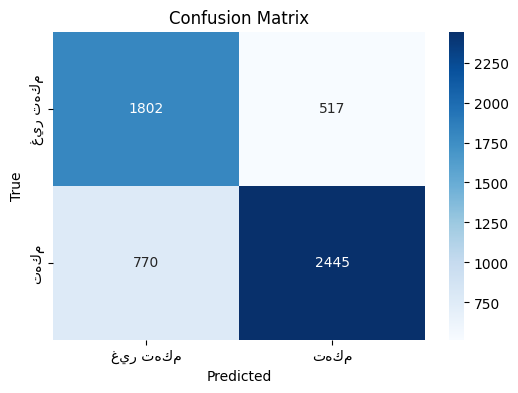

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["غير تهكم", "تهكم"],
    yticklabels=["غير تهكم", "تهكم"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(labels, preds, target_names=["غير تهكم", "تهكم"])
print(report)


              precision    recall  f1-score   support

    غير تهكم       0.70      0.78      0.74      2319
        تهكم       0.83      0.76      0.79      3215

    accuracy                           0.77      5534
   macro avg       0.76      0.77      0.76      5534
weighted avg       0.77      0.77      0.77      5534



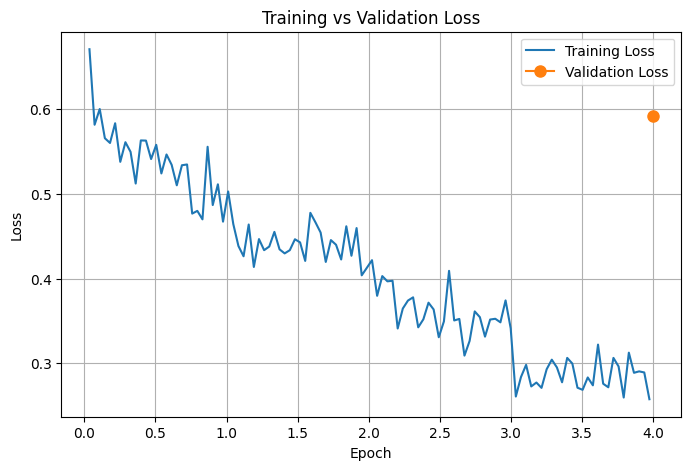

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = []
eval_loss = []
epochs_train = []
epochs_eval = []

for entry in logs:
    if "loss" in entry and "epoch" in entry and "eval_loss" not in entry:
        train_loss.append(entry["loss"])
        epochs_train.append(entry["epoch"])

    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
        epochs_eval.append(entry["epoch"])

plt.figure(figsize=(8,5))

plt.plot(epochs_train, train_loss, label="Training Loss")
plt.plot(epochs_eval, eval_loss, "o-", label="Validation Loss", markersize=8)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


المودل الثاني

In [ ]:
# ============================================
# 1) Loading AraELECTRA Model + Tokenizer
# ============================================

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import evaluate

model_name_electra = "aubmindlab/araelectra-base-discriminator"

tokenizer_electra = AutoTokenizer.from_pretrained(model_name_electra)

model_electra = AutoModelForSequenceClassification.from_pretrained(
    model_name_electra,
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_electra.to(device)

# ============================================
# 2) Tokenization
# ============================================

def tokenize(batch):
    return tokenizer_electra(batch["clean_text"], truncation=True)

train_tok = train_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_electra)

# ============================================
# 3) Metrics
# ============================================

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

# ============================================
# 4) Training Arguments  (نفس اللي قبل التوننق)
# ============================================

training_args = TrainingArguments(
    output_dir="araelectra_old_version",
    num_train_epochs=4,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none"
)

# ============================================
# 5) Trainer
# ============================================

trainer = Trainer(
    model=model_electra,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    tokenizer=tokenizer_electra,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# ============================================
# 6) Train + Evaluate
# ============================================

trainer.train()

results = trainer.evaluate()
print("\nAraELECTRA RESULTS:", results)

trainer.save_model("araelectra_finetuned")
tokenizer_electra.save_pretrained("araelectra_finetuned")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at aubmindlab/araelectra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/22132 [00:00<?, ? examples/s]

Map:   0%|          | 0/5534 [00:00<?, ? examples/s]

/tmp/ipython-input-3057043028.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.623000
100,0.568900
150,0.571700
200,0.552800
250,0.534500
300,0.545700
350,0.511900
400,0.538600
450,0.517400
500,0.488500



AraELECTRA RESULTS: {'eval_loss': 0.662777841091156, 'eval_accuracy': 0.7625587278641127, 'eval_f1': 0.7510065986191345, 'eval_runtime': 19.7779, 'eval_samples_per_second': 279.807, 'eval_steps_per_second': 17.494, 'epoch': 4.0}


('araelectra_finetuned/tokenizer_config.json',
 'araelectra_finetuned/special_tokens_map.json',
 'araelectra_finetuned/vocab.txt',
 'araelectra_finetuned/added_tokens.json',
 'araelectra_finetuned/tokenizer.json')

الانسمبل

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# ================================
# 1) Load AraBERT
# ================================
arabert_path = "arabert_old_finetuned"
tokenizer_bert = AutoTokenizer.from_pretrained(arabert_path)
model_bert = AutoModelForSequenceClassification.from_pretrained(arabert_path)
model_bert.to("cuda")
model_bert.eval()

# ================================
# 2) Load AraELECTRA
# ================================
electra_path = "araelectra_finetuned"
tokenizer_electra = AutoTokenizer.from_pretrained(electra_path)
model_electra = AutoModelForSequenceClassification.from_pretrained(electra_path)
model_electra.to("cuda")
model_electra.eval()

# ================================
# 3) Softmax probability for ANY text batch
# ================================
def get_probs(model, tokenizer, text_batch):
    inputs = tokenizer(text_batch, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs

# ================================
# 4) Ensemble predict for a single input
# ================================
def ensemble_predict(text, w1=0.5, w2=0.5):
    p1 = get_probs(model_bert, tokenizer_bert, [text])
    p2 = get_probs(model_electra, tokenizer_electra, [text])
    final_probs = (w1 * p1) + (w2 * p2)
    final_label = np.argmax(final_probs, axis=1)[0]
    return final_label, final_probs

# ================================
# 5) Evaluation with batching to avoid OOM
# ================================
texts = test_df["clean_text"].tolist()
true_labels = test_df["label"].values

batch_size = 32    # تقدرين تخفضينه لـ 16 إذا تبين

all_preds = []
all_probs = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]

    # Get model probabilities
    p1 = get_probs(model_bert, tokenizer_bert, batch_texts)
    p2 = get_probs(model_electra, tokenizer_electra, batch_texts)

    # Ensemble averaging
    final_p = (p1 + p2) / 2

    batch_preds = np.argmax(final_p, axis=1)

    all_preds.extend(batch_preds)
    all_probs.append(final_p)

all_probs = np.vstack(all_probs)

# ================================
# Metrics
# ================================
acc = accuracy_score(true_labels, all_preds)
f1 = f1_score(true_labels, all_preds, average="macro")
cm = confusion_matrix(true_labels, all_preds)

print("\n================ ENSEMBLE FINAL RESULTS ================\n")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1:.4f}\n")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, all_preds))


# ================================
# 6) single text example (optional)
# ================================
text = "يا شيخ كلامك ما يدخل الراس"
label, probs = ensemble_predict(text)

print("\nExample Prediction:")
print("Final Label:", label)
print("Ensemble Probabilities:", probs)


================ ENSEMBLE FINAL RESULTS ================

Accuracy: 0.7757
Macro F1: 0.7682

Confusion Matrix:
[[1646  673]
 [ 568 2647]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      2319
           1       0.80      0.82      0.81      3215

    accuracy                           0.78      5534
   macro avg       0.77      0.77      0.77      5534
weighted avg       0.77      0.78      0.77      5534


Example Prediction:
Final Label: 0
Ensemble Probabilities: [[0.93659306 0.06340702]]


In [ ]:
text = " اطقطق عليك اصلا يا شيخ كلامك ما يدخل الراس"

label, probs = ensemble_predict(text)

print("Final Label:", label)
print("Ensemble Probabilities:", probs)

Final Label: 1
Ensemble Probabilities: [[0.28863174 0.71136826]]


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import torch

# ============================================
# 1) دالة للحصول على احتمالات نموذج واحد
# ============================================

def get_probs(model, tokenizer, dataset):
    model.eval()
    all_probs = []

    for batch in dataset:
        inputs = tokenizer(
            batch["clean_text"],
            truncation=True,
            return_tensors="pt",
            padding=True
        )
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            all_probs.append(probs)

    return np.vstack(all_probs)

# ============================================
# 2) الحصول على احتمالات كل نموذج
# ============================================

probs_bert = get_probs(model_ara, tokenizer_ara, test_df.to_dict("records"))
probs_electra = get_probs(model_electra, tokenizer_electra, test_df.to_dict("records"))

# ============================================
# 3) دمج الاحتمالات (Ensemble)
# ============================================

ensemble_probs = (probs_bert + probs_electra) / 2.0
ensemble_preds = ensemble_probs.argmax(axis=1)

# ============================================
# 4) استخراج الـ Labels الحقيقية
# ============================================

true_labels = test_df["label"].values

# ============================================
# 5) حساب الـ Metrics
# ============================================

acc = accuracy_score(true_labels, ensemble_preds)
f1 = f1_score(true_labels, ensemble_preds, average="macro")
cm = confusion_matrix(true_labels, ensemble_preds)

print("====== ENSEMBLE FINAL METRICS ======")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n")
print(classification_report(true_labels, ensemble_preds))

====== ENSEMBLE FINAL METRICS ======
Accuracy: 0.7718
F1 Score: 0.7640

Confusion Matrix:
 [[1632  687]
 [ 576 2639]]

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      2319
           1       0.79      0.82      0.81      3215

    accuracy                           0.77      5534
   macro avg       0.77      0.76      0.76      5534
weighted avg       0.77      0.77      0.77      5534

